<a href="https://colab.research.google.com/github/zw2497/Neural_Network_PDE/blob/master/F_principle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip -q install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf 
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.math import sin
import time
%matplotlib inline
from scipy.fftpack import fft, fftfreq, fftshift
import scipy
from scipy.fftpack import fft

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.nn import relu

In [3]:
print("You have version", tf.__version__)
assert tf.__version__ >= "2.0" # TensorFlow ≥ 2.0 required

You have version 2.0.0-alpha0


# Build Function

In [0]:
def f(x):
    return sin(x) + 4 * sin(4*x) - 8 * sin(8*x) + 16 * sin(24*x)

def psy_trial(x, net_out):
    return (-1. - x) * (1. - x) * net_out

# Build Neural Network

In [0]:
model = Sequential()
model.add(Dense(128, input_shape=(None, 1), activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))
optimizer = tf.keras.optimizers.Adam(0.0005)

# Prepare Dataset

In [0]:
nx = 100
x_space = np.linspace(-1, 1, nx).astype('float32').reshape(nx,1)
x_space = tf.constant(x_space)

batch_size = 16
dataset = tf.data.Dataset.from_tensor_slices(x_space).batch(batch_size, drop_remainder=True)

In [7]:
example_batch = next(iter(dataset))
source = example_batch
print("Shapes:", source.shape)

Shapes: (16, 1)


# Train

In [0]:
def loss_function(y_true, y_pred):
    return keras.losses.mean_squared_error(y_true, y_pred)

In [0]:
@tf.function
def train_on_batch(x):
    with tf.GradientTape() as g_total:
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                net_out = model(x)
                psy_t = psy_trial(x, net_out)

            dy_dx = gg.gradient(psy_t, x)     # gradient
        d2y_dx2 = g.gradient(dy_dx, x)  # second order gradient
        
        func = f(x) # right part function
        loss = loss_function(-d2y_dx2, func)
#         print(d2y_dx2)

    grads = g_total.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    return tf.math.reduce_sum(loss)

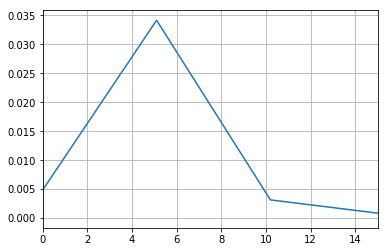

Epoch #0, Loss 1775.675415, Time 0.27 sec


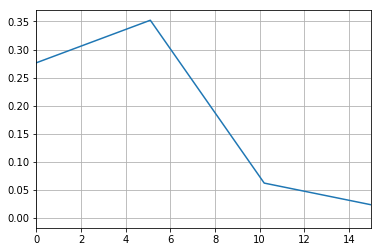

Epoch #100, Loss 1573.630005, Time 0.26 sec


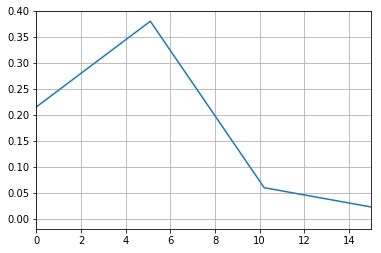

Epoch #200, Loss 1558.915039, Time 0.34 sec


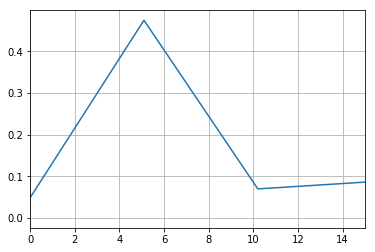

Epoch #300, Loss 1491.300415, Time 0.59 sec


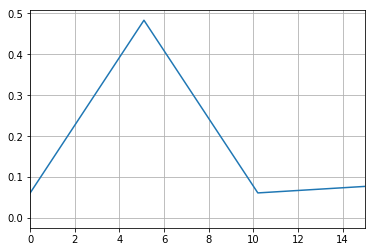

Epoch #400, Loss 1496.983398, Time 0.33 sec


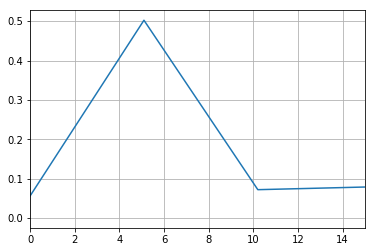

Epoch #500, Loss 1191.160645, Time 0.35 sec


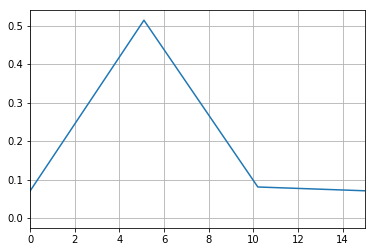

Epoch #600, Loss 917.536377, Time 0.26 sec


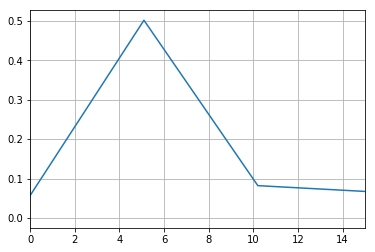

Epoch #700, Loss 598.820435, Time 0.32 sec


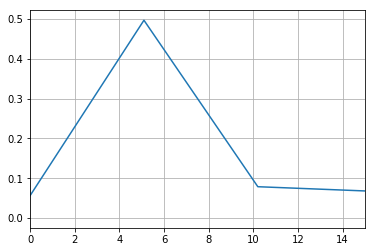

Epoch #800, Loss 422.620972, Time 0.29 sec


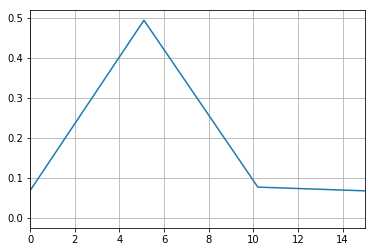

Epoch #900, Loss 242.523407, Time 0.22 sec


In [10]:
for epoch in range(1000):
    for batch, source_data in enumerate(dataset):
        start = time.time()
        loss = train_on_batch(source_data)
    if epoch % 100 == 0:
        plt.figure()
        res = psy_trial(x_space, model(x_space)).numpy().reshape(nx)
#         plt.plot(x_space, res)
#         plt.show()
        
        # Number of sample points
        N = 100
        # sample spacing
        T = 1.0 / 500.0
#         x = np.linspace(0.0, N*T, N)
#         y = np.sin(x) + 4*np.sin(4*x) -8*np.sin(8*x) + 16*np.sin(24*x)
        yf = fft(res)
        xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
        import matplotlib.pyplot as plt
        plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        plt.grid()
        plt.xlim(0,15)
        plt.show()
        
        print("Epoch #%d, Loss %.6f, Time %.2f sec" % (epoch, loss, time.time() - start))